In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import networkx as nx
import sys
sys.path.insert(0, 'utils/')
from GR_Maze_Utils import *
from GR_RL_Utils import *

from matplotlib import rc
rc('text', usetex=True)

%load_ext autoreload
%autoreload 2


In [2]:
def create_binary_tree_directed(levels):
    G = nx.DiGraph()
    G.add_nodes_from([('r')])
    #index = 0
    for l in range(1,levels+1):
        for i in range(2**l):
            bin_i = bin(i)[2:].zfill(l)
            G.add_nodes_from([('r'+ bin_i[::-1])])
    edges = []
                    
    edges += [('r','r0')]
    edges += [('r','r1')]
    
    for i in list(G.nodes):
        for j in list(G.nodes):
            if len(i) == len(j)+1 and j == i[:len(j)] and (i,j) not in edges and (j,i) not in edges:
                edges += [(i,j)]
    G = add_diedges_to_graph(G,edges)
    return G

def get_transition_matrix(levels): 
    G = create_binary_tree_directed(levels)
    index_to_state = get_index_to_state_vec(G)
    S = len(index_to_state)
    A = 3 #a= 0, go down left branch, a = 1, go down right branch, a = 2 go up the tree. 
    Tmat = np.zeros((S,A,S)) + 1e-6 #add small constant to avoid dividing by zero downstream. 
    for s in range(S):
        state = index_to_state[s]
        n1 = state[0]
        n2 = state[1]
        for a in range(A):
            if len(n2) == levels + 1 and a < 2: #at the leaf, turn back regardless
                n3 = n2[:-1]
            elif len(n2) == 1 and a == 2: 
                n3 = n2 + str(1-int(n1[-1]))#at the root, there's no going back up further go from 'r' to 'r1' or 'r' to 'r0' 
                                            #depending on whether you come from 'r0' or 'r1' resp. 
            else:
                if a == 2: #go up the tree
                    n3 = n2[:-1]
                else: #go left or right
                    n3 = n2 + str(a)
                    
            nextstate = (n2,n3)
            nextstate_index = get_state_index(nextstate,G)
            Tmat[s,a,nextstate_index] = 1
            
    Tmat /= np.sum(Tmat,axis=-1)[:,:,None]
    return Tmat

In [3]:
def run_RL_simulation(nepi,niter,renewtime, alpha = 0.01, gam = 0.98,lamb = 0.8, goal = ('r10010','r100101'),\
                     rew = 20,mode = 0, renew=False, q_mem_size = 15, dyna_mem_size = 500, dyna_plan_steps = 10):

    np.set_printoptions(precision = 3, suppress=True)
    #initialize environment

    rew_timer = 0
    G[goal[0]][goal[1]]['R'] = rew

    nodes = ['r']

    rews_received = 0
    cum_rews = []
    time_rews = []
    last_time = 0
    time_visits = []
    clock = 0
    
    params = [alpha,gam,lamb]
    
    dyna_mem = []

    for epi in range(nepi):
        #initialize state
        n0 = 'r'
        n1 = n0 + str(np.random.choice(2))
        state = (n0,n1) 

        nodes += [state[1]]

        q_mem = []

        for i in range(niter):
            rew_timer += 1
            clock += 1
            last_time += 1
            s_index = get_state_index(state,G)
            a = get_action(state,G)
            s_next = get_next_state(s_index,a,Tmat)
            prevstate = deepcopy(state)
            state = index_to_state[s_next]
            curr_rew = G[state[0]][state[1]]['R']

            nodes += [state[1]]
            
            sasr = [prevstate, a, state, curr_rew]
            
            if mode == 3:
                dyna_mem = update_memory_dyna(dyna_mem, sasr, dyna_mem_size)
            else:
                q_mem = update_memory_q(q_mem, sasr, q_mem_size)
            
            if mode == 0:
                G = update_Q_sQ(q_mem,sasr,goal,G,params) #sQ
            elif mode == 1:
                G = update_Q_Q(q_mem,sasr,goal,G,params) #Q
            elif mode == 2:
                G = update_Q_sarsa(q_mem,sasr,goal,G,params) #sarsa
            elif mode == 3:
                G = update_Q_dyna(dyna_mem,sasr,goal,G,params)

            if state == goal:
                if renew:
                    if G[goal[0]][goal[1]]['R'] > 1e-6:
                        rews_received += 1
                        cum_rews += [rews_received]
                        time_rews += [clock]
                        rew_timer = 0 
                    time_visits += [last_time]
                    last_time = 0
                else:
                    rews_received += 1
                    cum_rews += [rews_received]
                    time_rews += [rew_timer] 
                    time_visits += [last_time]
                    last_time = 0
                    break
                    
            if renew:
                if rew_timer > renewtime:
                    G[goal[0]][goal[1]]['R'] = rew
                else:
                    G[goal[0]][goal[1]]['R'] = 0
                    
            #print(state[0],a,state[-1],rew,last_time)

    return nodes,time_rews,cum_rews

### Get the number of direct paths when the agent is unrewarded. To be used as control. 

In [33]:
np.random.seed(0)

# Learning parameters
alpha = 0 
gam = 0
starts = [('r','r0'),('r','r1')]
goal = ('r10010','r100101')
rew = 0
niter = 5000
nepi = 100
renewtime = 60
lamb = 0.0 
mode = 2

nruns = 20
tmax = 7000

clrs = []

for i in range(nruns):
    G = create_binary_tree_directed(6)
    Tmat = get_transition_matrix(6)
    S = Tmat.shape[0]
    index_to_state = get_index_to_state_vec(G)
    
    Qe_mice = np.load("unrew_mice_Qvalues.npy")
    for s in range(S):
        state = index_to_state[s]
        G[state[0]][state[1]]['Qe'] = Qe_mice[s]
        G[state[0]][state[1]]['Qr'] = np.zeros(3)
        
    nodes,time_rews,cum_rews,Gs = run_RL_simulation(G,Tmat,starts, goal, nepi,niter,renewtime,lamb = lamb,\
                                    renew = False,alpha = alpha,gam=gam,rew= rew,mode=mode)

    thresh_run  = 7
    goal_node = 'r100101'

    runl_goal,times_goal = get_run_lengths_to_goal(nodes,[goal_node])
    cuml_lr,timl_lr = process_run_lengths(runl_goal,times_goal,thresh_run)

    ti = np.argmin(np.abs(np.array(timl_lr) - tmax))
    clr = cuml_lr[ti]
    clrs += [clr*tmax/timl_lr[ti]]
    print(clrs[-1])

13.08411214953271
12.47216035634744
7.644007644007644
3.7593984962406015
4.9184935356942105
4.005149477900157
12.91696238466998
7.7134986225895315
8.742714404662781
1.932367149758454
6.147540983606557
9.505129752564876
11.538461538461538
9.585102012871422
5.04759157773291
20.41113864994897
15.142774733198731
9.09484625378952
11.23431572804202
7.207413339434847


In [34]:
#compute mean and std of no. of direct paths in tmax
mean_ctrl = np.mean(clrs)
std_ctrl = np.std(clrs)
print(mean_ctrl, std_ctrl)

9.105158939552744 4.320888196937565


## Visualization of reinforcement propagation 

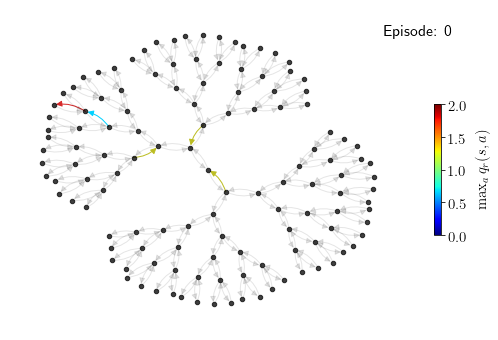

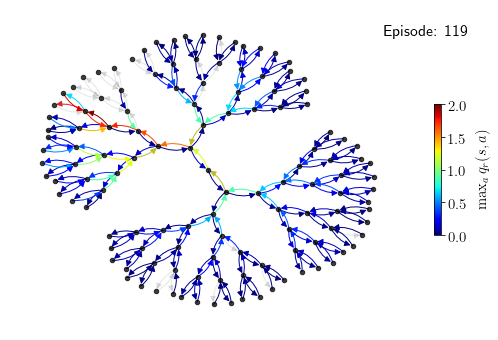

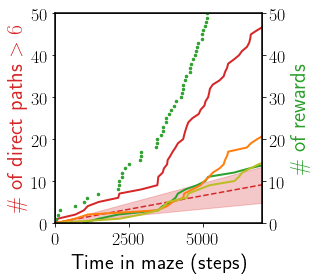

In [105]:
seed = 6 #example shown in paper
np.random.seed(seed)

# Learning parameters
alpha = 0.33 #learning rate.
gam = 0.99 #discount factor.
starts = [('r','r0'),('r','r1')]
goal = ('r10010','r100101')
rew = 2 #2
niter = 5000
nepi = 120
renewtime = 60
lamb = 0.0 #0.0

mode = 2 #expected SARSA

G = create_binary_tree_directed(6)
Tmat = get_transition_matrix(6)
S = Tmat.shape[0]
index_to_state = get_index_to_state_vec(G)

Qe_mice = np.load("unrew_mice_Qvalues.npy")
for s in range(S):
    state = index_to_state[s]
    G[state[0]][state[1]]['Qe'] = Qe_mice[s]
    G[state[0]][state[1]]['Qr'] = np.zeros(3)

nodes,time_rews,cum_rews,Gs = run_RL_simulation(G,Tmat,starts, goal, nepi,niter,renewtime,lamb = lamb,\
                                renew = False,alpha = alpha,gam=gam,rew= rew,mode=mode)

L = 7
show= [('r0','r'),('r11','r1'),('r101','r10')]
plot_graph_Qr(Gs[0], episode = 0, vmax = rew, goals = [goal], figsize = (9,6),show = show)
plot_graph_Qr(Gs[-1], episode = len(Gs)-1, vmax = rew, goals = [goal], figsize = (9,6),show = show)

plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (4.5,4))

#Long runs to goal
runl_goal,times_goal = get_run_lengths_to_goal(nodes,[goal_node])
cuml_lr,timl_lr = process_run_lengths(runl_goal,times_goal,thresh_run)
axis.plot(timl_lr,cuml_lr,'C3-',lw=2)

axis.fill_between([0,tmax],[0,mean_ctrl-std_ctrl],[0,mean_ctrl+std_ctrl],color = 'C3',alpha = 0.25)
axis.plot([0,tmax],[0,mean_ctrl],'C3--')

passing = ['r11','r0','r101']
colors = ['C2','C1','C8']
for pn,co in zip(passing,colors):
    lengths, times = get_run_lengths_to_goal(nodes,[goal[1]],passing_nodes = pn)
    filt = (lengths > L-1)
    timl_pn = times[filt]
    cuml_pn = np.arange(len(timl_pn))
    axis.plot(timl_pn,cuml_pn,co + '-',lw=2)

ax = axis.twinx()    
ax.plot(time_rews,cum_rews,'C2.',ms=5)

rmax = 50
tmax = 7000
axis.set_xlim(0,tmax)
axis.set_ylim(0,rmax)
axis.tick_params(labelsize = 18)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.5)
#axis.legend(fontsize = 15, frameon=False)
axis.set_xlabel("Time in maze (steps)",fontsize = 21)
axis.set_ylabel(r"\# of direct paths $> 6$",fontsize = 22, color = 'C3')
#axis.set_yticks([])
ax.set_ylim(0,rmax)
ax.tick_params(labelsize = 18)
ax.set_ylabel(r"\# of rewards",fontsize = 22, color = 'C2')

fig.tight_layout()
plt.show()

#### Output images to create movie

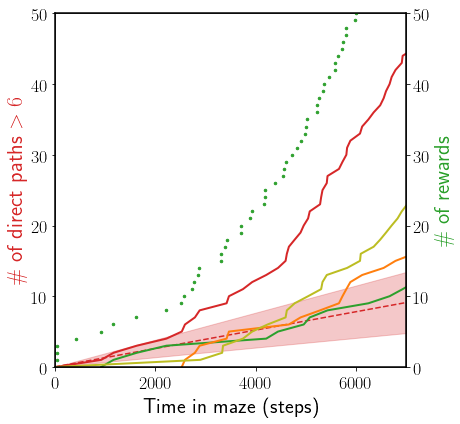

In [96]:
L = 7
name_prefix = "movie_exp_maze_s%d/movie"%seed
show= [('r0','r'),('r11','r1'),('r101','r10')]


for i in range(len(Gs[:])):
    G = Gs[i]
    plt.close("all")
    fig,axis = plt.subplots(1,1,figsize = (9,6))
    goals = [goal]
    norm = matplotlib.colors.Normalize(vmin=0, vmax=rew, clip=True)
    cmap = cm.jet
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    cs_e =[]
    for l in list(G.edges):
        v = np.max(G[l[0]][l[1]]['Qr'])
        if v < 1e-3:
            cs_e += [(0,0,0,0.1)]
        else:
            cs_e += [mapper.to_rgba(v)]
            
#     if starts is not None:
#         for start in starts:
#             for k,n in enumerate(list(G.edges)):
#                 if n[0] == start[0] and n[1] == start[1]:
#                     cs_e[k] = matplotlib.colors.to_rgba("C2")
                    
    if goals is not None:
        for goal in goals:
            for k,n in enumerate(list(G.edges)):
                if n[0] == goal[0] and n[1] == goal[1]:
                    cs_e[k] =  matplotlib.colors.to_rgba("C3")

    colors = ['C1','C2','C8']
    if show is not None:
        for si,s in enumerate(show):
            for k,n in enumerate(list(G.edges)):
                if n[0] == s[0] and n[1] == s[1]:
                    cs_e[k] = matplotlib.colors.to_rgba(colors[si])    

                    
    im = nx.draw_kamada_kawai(G, connectionstyle='arc3, rad = 0.2', ax = axis, edge_color = cs_e, arrowsize = 12, node_size = 20, node_color = 'k', alpha = 0.75)
    episode = i + 1
    axis.text(1,1,"Episode: "  + "{0:4d}".format(episode), fontsize = 16, fontfamily = "sans-serif")
    mapper._A = []
    cb  = fig.colorbar(mapper, shrink = 0.4)
    cb.set_label(r"$\max_a q_r(s,a)$", fontsize = 15, labelpad = 10)
    cb.ax.tick_params(labelsize = 15)
    
    save_name = "./movies/" + name_prefix + "_graph_%04d.png"%i
    if save_name is not None:
        fig.savefig(save_name, dpi = 100)
    else:
        plt.show()
    
    plt.close("all")
    fig,axis = plt.subplots(1,1,figsize = (6.5,6))

    #Long runs to goal
    runl_goal,times_goal = get_run_lengths_to_goal(nodes,[goal_node])
    cuml_lr,timl_lr = process_run_lengths(runl_goal,times_goal,thresh_run)
    axis.plot(timl_lr[:i],cuml_lr[:i],'C3-',lw=2)

    axis.fill_between([0,tmax],[0,mean_ctrl-std_ctrl],[0,mean_ctrl+std_ctrl],color = 'C3',alpha = 0.25)
    axis.plot([0,tmax],[0,mean_ctrl],'C3--')
    
    passing = ['r11','r0','r101']
    colors = ['C2','C1','C8']
    for pn,co in zip(passing,colors):
        lengths, times = get_run_lengths_to_goal(nodes,[goal[1]],passing_nodes = pn)
        filt = (lengths > L-1)*(times < time_rews[i])
        timl_pn = times[filt]
        cuml_pn = np.arange(len(timl_pn))
        axis.plot(timl_pn,cuml_pn,co + '-',lw=2)
    ax = axis.twinx()    
    ax.plot(time_rews[:i],cum_rews[:i],'C2.',ms=5)

    rmax = 50
    tmax = 7000
    axis.set_xlim(0,tmax)
    axis.set_ylim(0,rmax)
    axis.tick_params(labelsize = 18)
    for sp in ['top','bottom','left','right']:
        axis.spines[sp].set_linewidth(1.5)
    #axis.legend(fontsize = 15, frameon=False)
    axis.set_xlabel("Time in maze (steps)",fontsize = 21)
    axis.set_ylabel(r"\# of direct paths $> 6$",fontsize = 22, color = 'C3')
    #axis.set_yticks([])
    ax.set_ylim(0,rmax)
    ax.tick_params(labelsize = 18)
    ax.set_ylabel(r"\# of rewards",fontsize = 22, color = 'C2')

    fig.tight_layout()
    fig.savefig("./movies/" + name_prefix + "_curve_%04d.png"%(i), dpi = 100)
    #plt.show()

In [ ]:
ffmpeg -framerate 15 -pattern_type glob -i 'movie_curve_*.png' -c:v h264 -pix_fmt yuv420p -allow_sw 1 -vb 20M curve.mp4
ffmpeg -framerate 15 -pattern_type glob -i 'movie_graph_*.png' -c:v h264 -pix_fmt yuv420p -vb 20M graph.mp4
ffmpeg -i graph.mp4 -i curve.mp4 -filter_complex hstack=inputs=2 -vb 20M final.mp4

### Run simulations using SARSA(0) for ten seeds

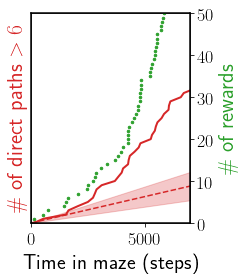

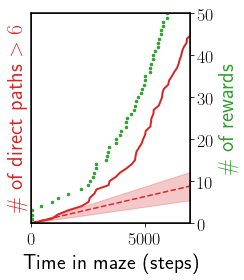

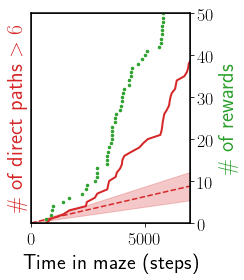

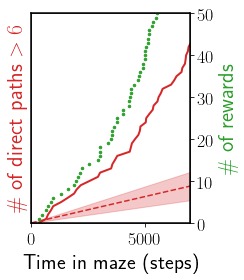

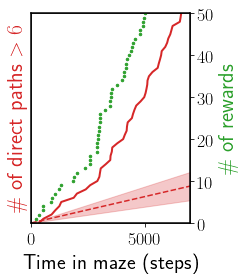

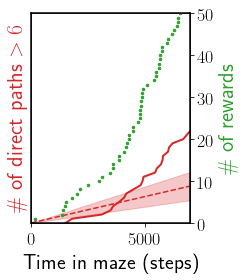

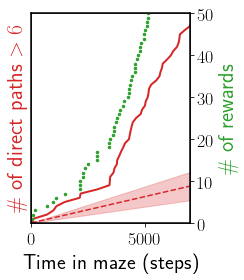

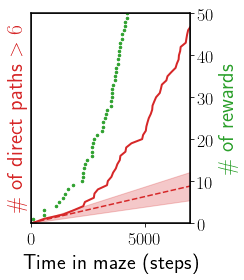

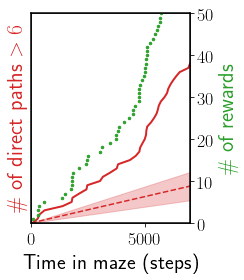

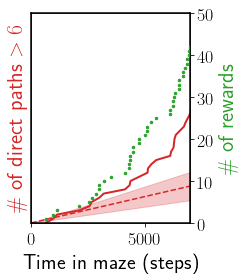

In [76]:
for s in range(10):
    np.random.seed(s)
    
    # Learning parameters
    alpha = 0.33 #learning rate. 0.33
    gam = 0.99 #discount factor. 0.99
    goal = ('r10010','r100101')
    rew = 2 #2
    niter = 5000
    nepi = 100
    renewtime = 60
    lamb = 0.0 #0.0

    mode = 2 #expected SARSA

    nodes,time_rews,cum_rews = run_RL_simulation(nepi,niter,renewtime,lamb = lamb,\
                                    renew = False,alpha = alpha,gam=gam,rew= rew,mode=mode)

    thresh_run  = 7
    goal_node = 'r100101'
    tmax = 7000
    rmax = 50

    plt.close("all")
    fig,axis = plt.subplots(1,1,figsize = (3.5,4))
    ax = axis.twinx()

    #Long runs to goal
    runl_goal,times_goal = get_run_lengths_to_goal(nodes,[goal_node])
    cuml_lr,timl_lr = process_run_lengths(runl_goal,times_goal,thresh_run)
    axis.plot(timl_lr,cuml_lr,'C3-',lw=2)

    axis.fill_between([0,tmax],[0,mean_ctrl-std_ctrl],[0,mean_ctrl+std_ctrl],color = 'C3',alpha = 0.25)
    axis.plot([0,tmax],[0,mean_ctrl],'C3--')
    if False:
        passing = ['r0','r101','r11','r01','r00']
        colors = ['m','y','c','C1','C0']

        for j in range(len(passing)):
            runl_goal,times_goal = get_run_lengths_to_goal(nodes,[goal_node],passing_nodes=passing[j])
            cuml,timl = process_run_lengths(runl_goal,times_goal,thresh_run)
            axis.plot(timl,cuml,colors[j],lw=3)

        #Long runs to controls

        ctrls = ['r111010','r011010','r000101']

        runl_ctrl,times_ctrl = get_run_lengths_to_goal(nodes,ctrls)
        cuml,timl = process_run_lengths(runl_ctrl,times_ctrl,thresh_run)
        axis.plot(timl,cuml/3,'b',lw=3)


    ax.plot(time_rews,cum_rews,'C2.',ms=5)

    axis.set_xlim(0,tmax)
    axis.set_ylim(0,rmax)
    axis.tick_params(labelsize = 18)
    for sp in ['top','bottom','left','right']:
        axis.spines[sp].set_linewidth(1.5)
    #axis.legend(fontsize = 15, frameon=False)
    axis.set_xlabel("Time in maze (steps)",fontsize = 21)
    axis.set_ylabel(r"\# of direct paths $> 6$",fontsize = 22, color = 'C3')
    axis.set_yticks([])
    ax.set_ylim(0,rmax)
    ax.tick_params(labelsize = 18)
    ax.set_ylabel(r"\# of rewards",fontsize = 22, color = 'C2')

    fig.tight_layout()
    fig.savefig("./plots/sims_water_runs_%dlen_seed%d.pdf"%(thresh_run-1,s))
    plt.show()

### Compute the log-likelihood of fitting a step vs ramp model for the number of direct paths

In [61]:
np.random.seed(0)
alpha = 0.33 #learning rate. 0.33
gam = 0.99 #discount factor. 0.99
goal = ('r10010','r100101')
rew = 2 #2
niter = 5000
nepi = 100
renewtime = 60
lamb = 0.0 #0.0

mode = 2 #sarsa

nruns = 200
Lsteps = np.zeros(nruns)
Lramps = np.zeros(nruns)

Lsig_params = np.zeros((nruns,4))

for l in range(nruns):
    nodes,time_rews,cum_rews = run_RL_simulation(nepi,niter,renewtime,lamb = lamb,\
                                    renew = False,alpha = alpha,gam=gam,rew= rew,mode=mode)
    
    thresh_run  = 7
    goal_node = 'r100101'
    #compute log-likelihood of step and ramp models. 
    Lstep,Lramp,Lsig = get_Lstep_Lramp_Lsig(nodes,goal_node,thresh_run,plot=False,xmax = 6000,ymax=45)
    
    Lsteps[l] = Lstep
    Lramps[l] = Lramp
    
    Lsig_params[l] = fit_sigmoid_directpath_rate(nodes,goal_node,thresh_run)
    
    #print(Lsig-Lstep,Lramp-Lstep)
    if l%10 == 1:
        print(l, np.mean(Lsteps[:l]-Lramps[:l]), np.mean(1/Lsig_params[:l,3]))
    #print("%.2f    %.2f" %(lamb,Lstep - Lramp))

1 0.5659250913538756 717.6346319715885
11 0.9773193651858453 699.1715655031537
21 1.2015675407388797 607.063528743544
31 1.244335306950256 639.887669835454
41 1.2305646083744415 665.1958806311399
51 1.2785187681116976 655.3972774891288
61 1.4220124742556157 652.0210417591537
71 1.3394723607247656 655.7033889919165
81 1.299033095171755 633.6595315496282
91 1.3260480242930908 643.176403025406
101 1.3308280422831593 678.6462474550152
111 1.3535784227812848 665.2633660726711
121 1.3409779177791186 668.6564016429869
131 1.3246470621338828 700.4567129296835
141 1.3614414445521061 683.2521868786442
151 1.2962738878460125 683.4068410512947
161 1.27444584515145 690.9155268121466
171 1.280269423559454 683.4120248091086
181 1.2990469796137647 665.9641088921821
191 1.2398799280830053 673.6320930751709


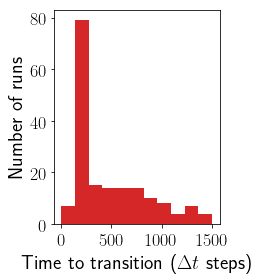

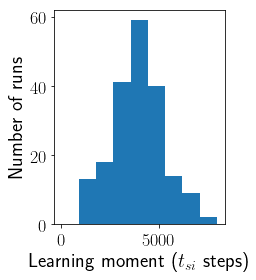

In [72]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize=(3.5,4)) 
axis.hist(1/Lsig_params[:,3], bins = np.linspace(0,1500,12),color='C3')
axis.tick_params(labelsize = 18)
axis.set_ylabel(r"Number of runs",fontsize = 20)
axis.set_xlabel(r"Time to transition ($\Delta t$ steps)", fontsize = 20)
axis.set_xticks([0,500,1000,1500])
#axis.set_yticks([0,10,20,30])
fig.tight_layout()
fig.savefig("./plots/sims_sig_transition.pdf")
plt.show()


plt.close("all")
fig,axis = plt.subplots(1,1,figsize=(3.5,4)) 
axis.hist(Lsig_params[:,2], bins = np.linspace(0,8000,10),color='C0')
axis.tick_params(labelsize = 18)
axis.set_ylabel(r"Number of runs",fontsize = 20)
axis.set_xlabel(r"Learning moment ($t_{si}$ steps)", fontsize = 20)
fig.tight_layout()
fig.savefig("./plots/sims_sig_moment.pdf")
plt.show()


### Lstep vs Lramp

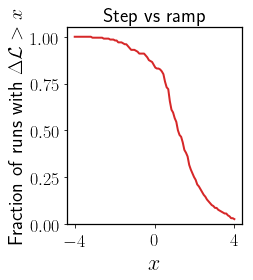

In [63]:
plt.close("all")
fig,axis = plt.subplots(1,1,figsize=(3.5,4))
xs = np.linspace(-4,4,100)
ps = []
for i,x in enumerate(xs):
    ps += [np.mean(Lsteps - Lramps > x)]
    
axis.plot(xs,ps,"C3-",lw=2)
axis.tick_params(labelsize = 18)
axis.set_ylabel(r"Fraction of runs with $\Delta \mathcal{L} > x$",fontsize = 20)
axis.set_xlabel(r"$x$", fontsize = 22)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.25)
axis.set_title("Step vs ramp",fontsize = 20)
axis.set_ylim(0,1.05)
axis.set_xticks([-4,0,4])
fig.tight_layout()
fig.savefig("./plots/sims_step_vs_ramp.pdf")
plt.show()

In [18]:
print(np.mean(Lsteps-Lramps))
print(np.mean(Lsteps-Lramps)/np.sqrt(len(Lsteps)))
print(np.mean(Lsteps > Lramps -1))

1.332420429762213
0.1332420429762213
0.93
